In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# creating engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflecting existing database into a new model and reflect tables
Base = automap_base()
Base.prepare(autoload_with=engine)


In [6]:
# Viewing classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Creating session (link) from Python to DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# View columns in Measurement table
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [10]:
# Finding most recent date the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

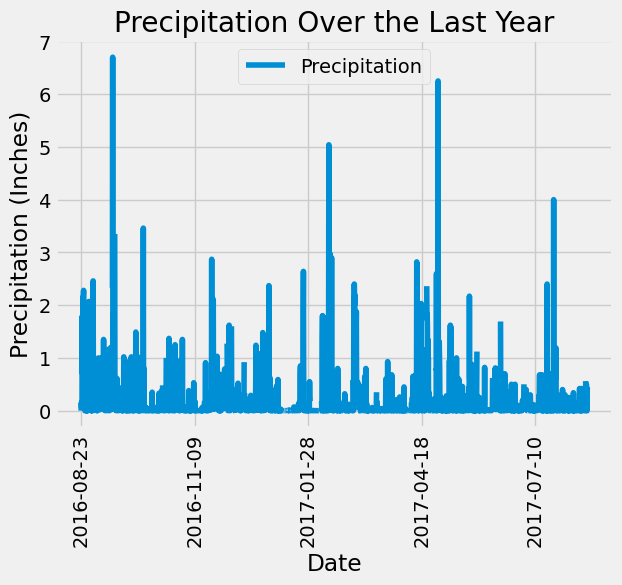

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculating date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

# Query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

# Saving query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_scores, columns=['Date', 'Precipitation'])

# Sort dataframe by date
precipitation_df.sort_values(by='Date', inplace=True)

# Plotting the data with Pandas and Matplotlib
precipitation_df.plot('Date', 'Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title('Precipitation Over the Last Year')
plt.xticks(rotation='vertical')
plt.show()

In [12]:
# Calculating summary stats for precipitation data
summary_stats = precipitation_df['Precipitation'].describe().to_frame()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Viewing columns in Station dataset
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [14]:
# Query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).distinct().all()

[(9,)]

In [15]:
# Query to find the most active stations (i.e. most rows/observations)
session.query(Measurement.station, func.count(Measurement.id)).\
    join(Station, Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Calculate the lowest, highest, and average temperature for most active station
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).\
              filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

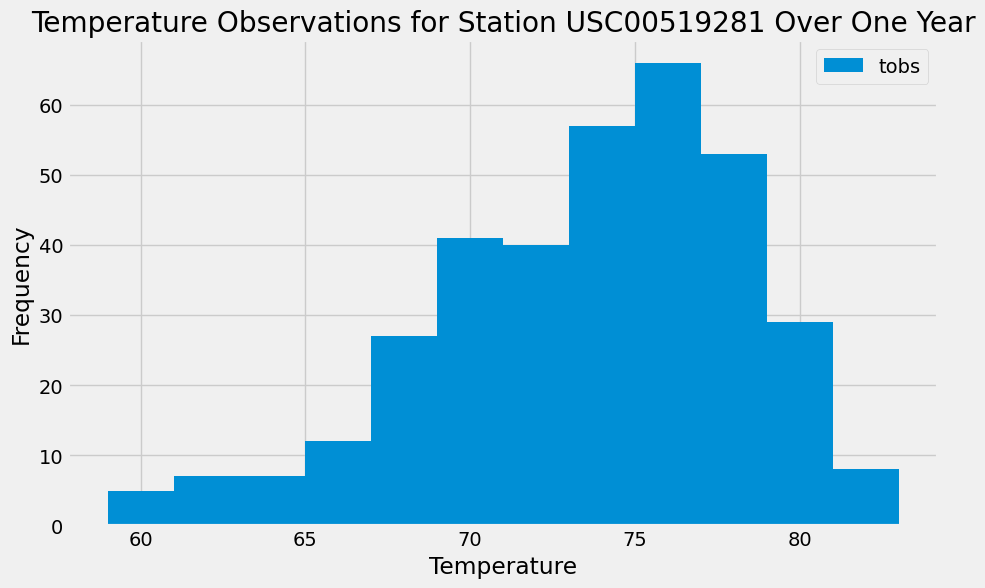

In [17]:
# Query the last 12 months of temperature observation data for most active station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.station =='USC00519281').\
            filter(Measurement.date >= year_ago).all()

# Extract temperatures from query results
temperatures = [result[1] for result in results]

# Plotting results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("Temperature Observations for Station USC00519281 Over One Year")
plt.legend()
plt.show()


# Close Session

In [18]:
# Close Session
session.close()